In [87]:
%matplotlib inline

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

In [88]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.0.2


In [89]:
RT_LIMIT_LOWER = 4340
RT_LIMIT_UPPER = 4580

In [90]:
BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [91]:
CONVERTED_DATABASE_NAME

'/home/ubuntu/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [92]:
feature_list_filename = "{}/HeLa_20KInt-feature-list.csv".format(BASE_NAME)
feature_list_df = pd.read_csv(feature_list_filename)

In [93]:
allpeptides_df = pd.read_csv('/home/ubuntu/maxquant_results/txt/allPeptides.txt', sep='\t')

In [94]:
len(allpeptides_df)

328862

In [95]:
allpeptides_df.head()

,Raw file,Charge,m/z,Mass,Resolution,Number of data points,Number of frames,Number of isotopic peaks,Isotope correlation,Mass fractional part,...,Min frame index,Max frame index,Ion mobility index,Ion mobility index length,Ion mobility index length (FWHM),Intensity,Intensities,Number of pasef MS/MS,Pasef MS/MS IDs,MS/MS scan number
0,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,326.37791,325.37063,24329.390330,3048,20,2,0.999609,0.370635,...,5137,5156,363,54,27,31429.0,NaN,0,NaN,NaN
1,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,312.32607,311.31879,24234.331350,19515,75,2,0.992528,0.318792,...,5351,5425,501,51,21,81118.0,NaN,0,NaN,NaN
2,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,316.28438,315.27711,24449.285122,706,7,2,0.999514,0.277105,...,5112,5118,549,75,27,36051.0,NaN,0,NaN,NaN
3,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,307.09608,306.08880,24469.582565,7633,22,2,0.998656,0.088801,...,4935,4956,651,111,30,295110.0,NaN,0,NaN,NaN
4,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,316.16858,315.16130,24514.638897,108,3,2,0.999752,0.161303,...,5032,5034,645,21,18,7543.2,NaN,0,NaN,NaN


In [96]:
allpeptides_df.rename(columns={'Number of isotopic peaks': 'isotope_count', 'm/z': 'mz', 'Intensity': 'intensity', 'Ion mobility index':'scan', 'Retention time': 'rt', 'Charge': 'charge_state'}, inplace=True)

In [97]:
feature_list_df.head()

,feature_id,charge_state,monoisotopic_mass,feature_centroid_scan,feature_centroid_rt,feature_centroid_mz,feature_start_rt,feature_end_rt,feature_scan_lower,feature_scan_upper,...,base_peak_scan_lower,base_peak_scan_upper,base_peak_centroid_rt,base_peak_std_dev_rt,base_peak_rt_lower,base_peak_rt_upper,base_peak_centroid_mz,base_peak_std_dev_mz,base_peak_mz_lower,base_peak_mz_upper
0,1,2,1789.903876,432.554732,4432.861258,896.398529,4427.824409,4443.177867,422,442,...,422,442,4433.020714,2.598279,4430.187565,4440.816682,895.958387,0.004415,895.917833,895.998069
1,2,2,1753.793257,414.272995,4459.104625,878.396096,4449.083986,4471.506226,405,425,...,405,425,4459.755071,4.440888,4449.083986,4471.506226,878.405911,0.006066,878.371983,878.442083
2,3,2,1658.901506,438.122446,4400.319978,830.627797,4390.028733,4412.471973,426,446,...,426,446,4400.557071,2.519410,4390.028733,4412.471973,830.458480,0.005567,830.406597,830.492932
3,4,2,1424.730227,486.765365,4533.062044,713.624696,4519.935285,4542.374700,472,492,...,472,492,4532.433233,3.352277,4529.382170,4542.374700,713.372265,0.002964,713.340924,713.404096
4,5,2,1424.729543,482.752245,4529.693034,713.687159,4519.935285,4540.014544,478,496,...,478,493,4529.118263,3.873986,4519.935285,4540.014544,713.372338,0.005519,713.340924,713.408308


In [98]:
feature_list_subset_df = feature_list_df[["feature_id","mono_peak_centroid_mz","mono_peak_centroid_rt","mono_peak_centroid_scan","monoisotopic_mass","feature_summed_intensity","charge_state"]].copy()

In [99]:
feature_list_subset_df.sort_values(by=['feature_summed_intensity'], ascending=False, inplace=True)

In [100]:
allpeptides_subset_df = allpeptides_df[["mz","intensity","charge_state","rt","scan"]].copy()
allpeptides_subset_df = allpeptides_subset_df[(allpeptides_subset_df.rt >= RT_LIMIT_LOWER) & (allpeptides_subset_df.rt <= RT_LIMIT_UPPER)]

In [101]:
allpeptides_subset_df.sort_values(by=['intensity'], ascending=False).head()

,mz,intensity,charge_state,rt,scan
273238,895.95670,26707000.0,2,4432.552,363
271311,877.90152,16367000.0,2,4457.345,411
258239,830.45670,10780000.0,2,4398.299,435
272371,890.44758,9524100.0,2,4512.851,348
257004,821.89394,8506200.0,2,4536.471,465


Enumerate the MQ features

In [102]:
allpeptides_subset_df = allpeptides_subset_df[allpeptides_subset_df.intensity.notnull()].copy()

allpeptides_subset_df.sort_values(by=['intensity'], ascending=False, inplace=True)
allpeptides_subset_df["mq_feature_id"] = np.arange(start=1, stop=len(allpeptides_subset_df)+1)

In [103]:
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4 
RT_TOLERANCE_SECS = 5
DRIFT_TOLERANCE = 5

allpeptides_subset_df["mz_delta"] = allpeptides_subset_df.mz * MZ_TOLERANCE_PERCENT / 100
allpeptides_subset_df["mz_upper"] = allpeptides_subset_df.mz + allpeptides_subset_df.mz_delta
allpeptides_subset_df["mz_lower"] = allpeptides_subset_df.mz - allpeptides_subset_df.mz_delta

allpeptides_subset_df["rt_upper"] = allpeptides_subset_df.rt + RT_TOLERANCE_SECS
allpeptides_subset_df["rt_lower"] = allpeptides_subset_df.rt - RT_TOLERANCE_SECS

allpeptides_subset_df["drift_upper"] = allpeptides_subset_df.scan + DRIFT_TOLERANCE
allpeptides_subset_df["drift_lower"] = allpeptides_subset_df.scan - DRIFT_TOLERANCE

In [104]:
allpeptides_subset_df.head()

,mz,intensity,charge_state,rt,scan,mq_feature_id,mz_delta,mz_upper,mz_lower,rt_upper,rt_lower,drift_upper,drift_lower
273238,895.95670,26707000.0,2,4432.552,363,1,0.004480,895.961180,895.952220,4437.552,4427.552,368,358
271311,877.90152,16367000.0,2,4457.345,411,2,0.004390,877.905910,877.897130,4462.345,4452.345,416,406
258239,830.45670,10780000.0,2,4398.299,435,3,0.004152,830.460852,830.452548,4403.299,4393.299,440,430
272371,890.44758,9524100.0,2,4512.851,348,4,0.004452,890.452032,890.443128,4517.851,4507.851,353,343
257004,821.89394,8506200.0,2,4536.471,465,5,0.004109,821.898049,821.889831,4541.471,4531.471,470,460


In [105]:
match_list = []

for mq_idx in range(len(allpeptides_subset_df)):
    mq_feature_df = allpeptides_subset_df.iloc[mq_idx]
    
    mq_feature_id = mq_feature_df.mq_feature_id
    
    mz_lower = mq_feature_df.mz_lower
    mz_upper = mq_feature_df.mz_upper
    rt_lower = mq_feature_df.rt_lower
    rt_upper = mq_feature_df.rt_upper
    drift_lower = mq_feature_df.drift_lower
    drift_upper = mq_feature_df.drift_upper
    charge_state = mq_feature_df.charge_state

    matches_df = feature_list_subset_df[
                                (
                                    (feature_list_subset_df.mono_peak_centroid_mz >= mz_lower) &
                                    (feature_list_subset_df.mono_peak_centroid_mz <= mz_upper)
                                ) &
                                (
                                    (feature_list_subset_df.mono_peak_centroid_rt >= rt_lower) &
                                    (feature_list_subset_df.mono_peak_centroid_rt <= rt_upper)
                                ) &
                                (
                                    (feature_list_subset_df.mono_peak_centroid_scan >= drift_lower) &
                                    (feature_list_subset_df.mono_peak_centroid_scan <= drift_upper)
                                ) &
                                (
                                    charge_state == feature_list_subset_df.charge_state
                                )
    ]
    
    for match_idx in range(len(matches_df)):
        feature_id = matches_df.iloc[match_idx].feature_id
        match_list.append((int(mq_feature_id), int(feature_id)))


In [106]:
match_list_df = pd.DataFrame(match_list, columns=['mq_feature_id','feature_id'])

In [107]:
len(match_list_df)

2593

In [108]:
match_list_df.sort_values(by=['mq_feature_id'], ascending=True, inplace=False).head()

,mq_feature_id,feature_id
0,1,39
1,2,2
2,2,207
3,3,45
4,3,3


In [109]:
mq_feature_match_counts = match_list_df.mq_feature_id.value_counts()

In [110]:
mq_feature_match_counts.tail()

2258    1
211     1
213     1
2262    1
2047    1
Name: mq_feature_id, dtype: int64

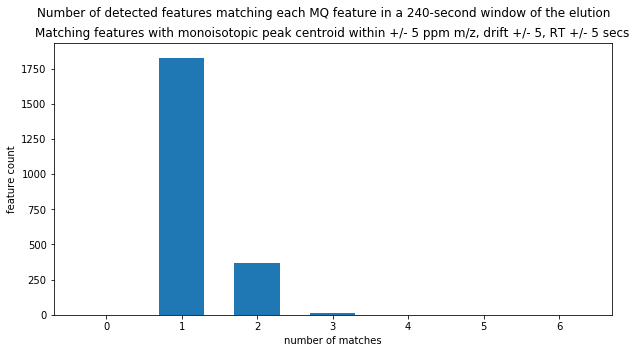

In [111]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(10)
plt.hist(mq_feature_match_counts, bins=np.arange(start=0, stop=8)-0.5, rwidth=0.6)
plt.xlabel('number of matches')
plt.ylabel('feature count')
plt.margins(0.06)
plt.suptitle('Number of detected features matching each MQ feature in a {}-second window of the elution'.format(RT_LIMIT_UPPER-RT_LIMIT_LOWER))
plt.title('Matching features with monoisotopic peak centroid within +/- {} ppm m/z, drift +/- {}, RT +/- {} secs'.format(MZ_TOLERANCE_PPM, DRIFT_TOLERANCE, RT_TOLERANCE_SECS))
plt.show()

For each detected feature, how many matching MQ features are there?

In [112]:
feature_list_subset_df["mz_delta"] = feature_list_subset_df.mono_peak_centroid_mz * MZ_TOLERANCE_PERCENT / 100
feature_list_subset_df["mz_upper"] = feature_list_subset_df.mono_peak_centroid_mz + feature_list_subset_df.mz_delta
feature_list_subset_df["mz_lower"] = feature_list_subset_df.mono_peak_centroid_mz - feature_list_subset_df.mz_delta

feature_list_subset_df["rt_upper"] = feature_list_subset_df.mono_peak_centroid_rt + RT_TOLERANCE_SECS
feature_list_subset_df["rt_lower"] = feature_list_subset_df.mono_peak_centroid_rt - RT_TOLERANCE_SECS

feature_list_subset_df["drift_upper"] = feature_list_subset_df.mono_peak_centroid_scan + DRIFT_TOLERANCE
feature_list_subset_df["drift_lower"] = feature_list_subset_df.mono_peak_centroid_scan - DRIFT_TOLERANCE

In [113]:
match_list = []

for idx in range(len(feature_list_subset_df)):
    feature_df = feature_list_subset_df.iloc[idx]
    
    feature_id = feature_df.feature_id
    
    mz_lower = feature_df.mz_lower
    mz_upper = feature_df.mz_upper
    rt_lower = feature_df.rt_lower
    rt_upper = feature_df.rt_upper
    drift_lower = feature_df.drift_lower
    drift_upper = feature_df.drift_upper
    charge_state = feature_df.charge_state

    matches_df = allpeptides_subset_df[
                                (
                                    (allpeptides_subset_df.mz >= mz_lower) &
                                    (allpeptides_subset_df.mz <= mz_upper)
                                ) &
                                (
                                    (allpeptides_subset_df.rt >= rt_lower) &
                                    (allpeptides_subset_df.rt <= rt_upper)
                                ) &
                                (
                                    (allpeptides_subset_df.scan >= drift_lower) &
                                    (allpeptides_subset_df.scan <= drift_upper)
                                ) &
                                (
                                    charge_state == allpeptides_subset_df.charge_state
                                )
    ]
    
    for match_idx in range(len(matches_df)):
        mq_feature_id = matches_df.iloc[match_idx].mq_feature_id
        match_list.append((int(feature_id), int(mq_feature_id)))


In [114]:
mq_match_list_df = pd.DataFrame(match_list, columns=['feature_id','mq_feature_id'])

In [115]:
mq_match_list_df.head()

,feature_id,mq_feature_id
0,33,20
1,46,14
2,60,79
3,72,51
4,27,241


In [116]:
len(mq_match_list_df)

2593

In [117]:
mq_match_list_df.sort_values(by=['feature_id'], ascending=True, inplace=False).head()

,feature_id,mq_feature_id
7,2,2
99,3,3
5,7,35
16,23,52
9,26,8


In [118]:
mq_match_list_df.sort_values(by=['feature_id'], ascending=True, inplace=False).tail()

,feature_id,mq_feature_id
2334,9434,1855
2478,9436,1745
2537,9438,6974
2427,9439,7171
2484,9440,3599


In [119]:
feature_match_counts = mq_match_list_df.feature_id.value_counts()

In [120]:
feature_match_counts.tail()

2670    1
2668    1
619     1
8809    1
4096    1
Name: feature_id, dtype: int64

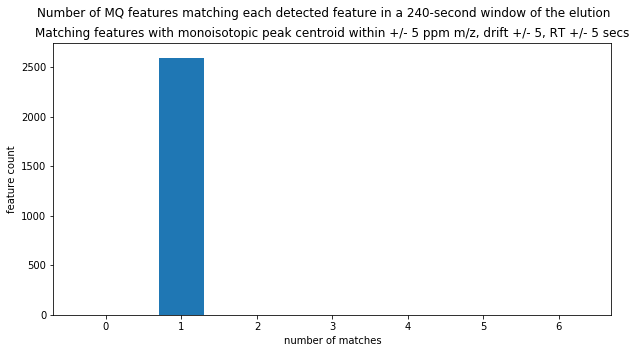

In [121]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(10)
plt.hist(feature_match_counts, bins=np.arange(start=0, stop=8)-0.5, rwidth=0.6)
plt.xlabel('number of matches')
plt.ylabel('feature count')
plt.margins(0.06)
plt.suptitle('Number of MQ features matching each detected feature in a {}-second window of the elution'.format(RT_LIMIT_UPPER-RT_LIMIT_LOWER))
plt.title('Matching features with monoisotopic peak centroid within +/- {} ppm m/z, drift +/- {}, RT +/- {} secs'.format(MZ_TOLERANCE_PPM, DRIFT_TOLERANCE, RT_TOLERANCE_SECS))
plt.show()

In [122]:
# total features found by MQ
len(allpeptides_subset_df)

16610

In [123]:
# features found by MQ also found by my pipeline
len(match_list_df)

2593

In [124]:
# total features found by my pipeline
len(feature_list_subset_df)

9318

In [125]:
feature_list_subset_df.sort_values(by=['feature_summed_intensity'], ascending=False, inplace=False).head()

,feature_id,mono_peak_centroid_mz,mono_peak_centroid_rt,mono_peak_centroid_scan,monoisotopic_mass,feature_summed_intensity,charge_state,mz_delta,mz_upper,mz_lower,rt_upper,rt_lower,drift_upper,drift_lower
14,16,561.288657,4399.253358,635.482727,1120.563433,6320648,2,0.002806,561.291464,561.285851,4404.253358,4394.253358,640.482727,630.482727
4,5,713.372338,4529.118263,482.402279,1424.729543,6165001,2,0.003567,713.375905,713.368771,4534.118263,4524.118263,487.402279,477.402279
31,33,648.880952,4465.630934,547.362841,1295.747012,5424951,2,0.003244,648.884197,648.877708,4470.630934,4460.630934,552.362841,542.362841
44,46,681.025846,4423.473243,498.254684,2040.053006,5330614,3,0.003405,681.029251,681.022440,4428.473243,4418.473243,503.254684,493.254684
58,60,530.779643,4416.990095,661.146634,1059.544137,4879618,2,0.002654,530.782297,530.776989,4421.990095,4411.990095,666.146634,656.146634


In [261]:
match_list_df.sort_values(by=['mq_feature_id'], ascending=True, inplace=False).head(50)

,mq_feature_id,feature_id
0,1,39
1,2,2
2,2,207
3,3,45
4,3,3
5,5,279
8,6,116
9,6,634
6,6,51
7,6,81


In [127]:
match_list_df.sort_values(by=['feature_id'], ascending=True, inplace=False).head()

,mq_feature_id,feature_id
1,2,2
4,3,3
43,35,7
62,52,23
12,8,26


Visualise an MQ feature that I missed

In [326]:
MQ_FEATURE_ID_NOT_MATCHED = 33

In [327]:
mq_feature_df = allpeptides_subset_df[allpeptides_subset_df.mq_feature_id == MQ_FEATURE_ID_NOT_MATCHED]
mq_feature_df

,mz,intensity,charge_state,rt,scan,mq_feature_id,mz_delta,mz_upper,mz_lower,rt_upper,rt_lower,drift_upper,drift_lower
278150,902.42968,2703500.0,4,4424.281,468,33,0.004512,902.434192,902.425168,4429.281,4419.281,473,463


In [328]:
mz_lower = mq_feature_df.mz_lower.values[0] - 4
mz_upper = mq_feature_df.mz_upper.values[0] + 4
rt_lower = mq_feature_df.rt.values[0] - 0.5
rt_upper = mq_feature_df.rt.values[0] + 0.5
drift_lower = mq_feature_df.drift_lower.values[0] - 20
drift_upper = mq_feature_df.drift_upper.values[0] + 20

In [329]:
feature_isotopes_filename = "{}/HeLa_20KInt-feature-isotopes.csv".format(BASE_NAME)
feature_isotopes_df = pd.read_csv(feature_isotopes_filename)

In [330]:
feature_isotopes_df.head()

,feature_id,feature_region_peak_id,centroid_scan,centroid_rt,centroid_mz,peak_summed_intensity
0,1,1,431.541637,4433.020714,895.958387,1828345
1,1,2,433.271139,4433.358048,896.460127,1434429
2,1,3,432.919773,4432.153007,896.964310,1023359
3,1,4,436.075284,4430.680979,897.470706,128128
4,2,2,415.517356,4459.626480,877.904042,1377563


In [331]:
# find all the feature region peaks nearby
nearby_feature_peaks_df = feature_isotopes_df[
                                (
                                    (feature_isotopes_df.centroid_mz >= mz_lower) &
                                    (feature_isotopes_df.centroid_mz <= mz_upper)
                                ) &
                                (
                                    (feature_isotopes_df.centroid_rt >= rt_lower) &
                                    (feature_isotopes_df.centroid_rt <= rt_upper)
                                ) &
                                (
                                    (feature_isotopes_df.centroid_scan >= drift_lower) &
                                    (feature_isotopes_df.centroid_scan <= drift_upper)
                                )
                            ]

In [332]:
nearby_feature_ids = nearby_feature_peaks_df.feature_id.unique().tolist()

In [333]:
nearby_feature_ids

[275, 648, 1083, 1091, 1474, 1547, 2182, 2738]

In [334]:
nearby_feature_points_df_list = []
for feature_id in nearby_feature_ids:
    SUMMED_REGIONS_DATABASE = '{}/HeLa_20KInt-features-{}-{}.sqlite'.format(BASE_NAME, feature_id, feature_id)
    db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
    nearby_feature_points_df = pd.read_sql_query("select * from summed_ms1_regions where (feature_id,peak_id) in (select feature_id,feature_region_peak_id from feature_isotopes where feature_id={})".format(feature_id), db_conn)
    nearby_feature_points_df["marker_size"] = (((np.log(nearby_feature_points_df.intensity)-5)*2)**2)*4
    nearby_feature_points_df_list.append((nearby_feature_points_df))
    db_conn.close()

In [335]:
summed_region_points_df_list = []
for feature_id in nearby_feature_ids:
    SUMMED_REGIONS_DATABASE = '{}/HeLa_20KInt-features-{}-{}.sqlite'.format(BASE_NAME, feature_id, feature_id)
    db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
    summed_region_points_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id={}".format(feature_id), db_conn)
    summed_region_points_df["marker_size"] = (((np.log(nearby_feature_points_df.intensity)-5)*2)**2)*4
    summed_region_points_df_list.append((summed_region_points_df))
    db_conn.close()

In [336]:
# find all the other MQ features nearby
nearby_mq_features_df = allpeptides_subset_df[
                                (
                                    (allpeptides_subset_df.mz >= mz_lower) &
                                    (allpeptides_subset_df.mz <= mz_upper)
                                ) &
                                (
                                    (allpeptides_subset_df.rt >= rt_lower) &
                                    (allpeptides_subset_df.rt <= rt_upper)
                                ) &
                                (
                                    (allpeptides_subset_df.scan >= drift_lower) &
                                    (allpeptides_subset_df.scan <= drift_upper)
                                )
                            ]

In [337]:
nearby_mq_features_df

,mz,intensity,charge_state,rt,scan,mq_feature_id,mz_delta,mz_upper,mz_lower,rt_upper,rt_lower,drift_upper,drift_lower
278150,902.42968,2703500.0,4,4424.281,468,33,0.004512,902.434192,902.425168,4429.281,4419.281,473,463


In [338]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

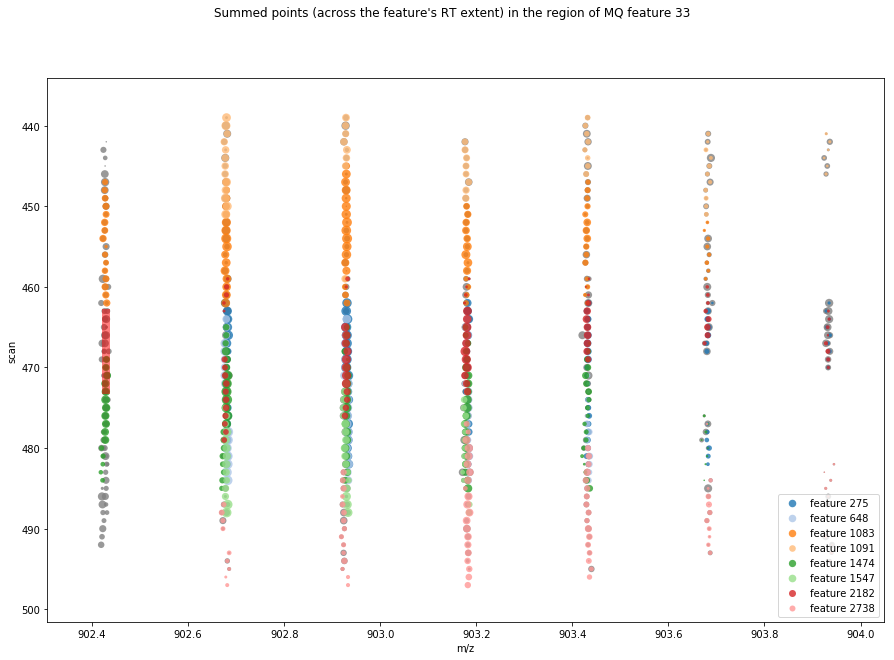

In [339]:
import matplotlib.patches as patches

f, ax = plt.subplots()
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()

# draw the MQ feature rectangle
mz_lower = mq_feature_df.mz_lower.values[0]
drift_lower = mq_feature_df.drift_lower.values[0]
mz_range = mq_feature_df.mz_upper.values[0] - mq_feature_df.mz_lower.values[0]
drift_range = mq_feature_df.drift_upper.values[0] - mq_feature_df.drift_lower.values[0]
mq_feature_rect = patches.Rectangle((mz_lower, drift_lower), mz_range, drift_range, linewidth=4, alpha=0.5, linestyle='-', edgecolor='r', facecolor='none')
ax.add_patch(mq_feature_rect)

# show all the summed points of nearby features
for idx,feature_id in enumerate(nearby_feature_ids):
    summed_region_points_df = summed_region_points_df_list[idx]
    ax.scatter(summed_region_points_df.mz, summed_region_points_df.scan, marker='.', color='gray', lw=0, s=summed_region_points_df.marker_size, alpha=0.8)

# show only the summed points of nearby feature isotopes
scatter_groups = []
for idx,feature_id in enumerate(nearby_feature_ids):
    nearby_feature_points_df = nearby_feature_points_df_list[idx]
    scatter = ax.scatter(nearby_feature_points_df.mz, nearby_feature_points_df.scan, marker='.', color=tableau20_mpl[idx], lw=0, s=nearby_feature_points_df.marker_size, alpha=0.8, label="feature {}".format(feature_id))
    scatter_groups.append((scatter))

plt.legend(handles=scatter_groups, loc='lower right')
f.set_figheight(10)
f.set_figwidth(15)
plt.suptitle('Summed points (across the feature\'s RT extent) in the region of MQ feature {}'.format(MQ_FEATURE_ID_NOT_MATCHED))
plt.margins(0.06)
plt.show()

In [349]:
NEARBY_CANDIDATE_FEATURE_ID = 275

In [350]:
feature_df = feature_list_subset_df[feature_list_subset_df.feature_id==NEARBY_CANDIDATE_FEATURE_ID]
feature_df

,feature_id,mono_peak_centroid_mz,mono_peak_centroid_rt,mono_peak_centroid_scan,monoisotopic_mass,feature_summed_intensity,charge_state,mz_delta,mz_upper,mz_lower,rt_upper,rt_lower,drift_upper,drift_lower
272,275,902.681482,4422.927997,470.596699,3606.693163,763902,4,0.004513,902.685995,902.676968,4427.927997,4417.927997,475.596699,465.596699


In [351]:
mq_feature = allpeptides_subset_df[allpeptides_subset_df.mq_feature_id==MQ_FEATURE_ID_NOT_MATCHED]
mq_feature

,mz,intensity,charge_state,rt,scan,mq_feature_id,mz_delta,mz_upper,mz_lower,rt_upper,rt_lower,drift_upper,drift_lower
278150,902.42968,2703500.0,4,4424.281,468,33,0.004512,902.434192,902.425168,4429.281,4419.281,473,463


In [352]:
# RT
rt_match = (feature_df.mono_peak_centroid_rt.values[0] >= mq_feature.rt_lower.values[0]) & (feature_df.mono_peak_centroid_rt.values[0] <= mq_feature.rt_upper.values[0])

In [353]:
# m/z
mz_match = (feature_df.mono_peak_centroid_mz.values[0] >= mq_feature.mz_lower.values[0]) & (feature_df.mono_peak_centroid_mz.values[0] <= mq_feature.mz_upper.values[0])

In [354]:
# drift
drift_match = (feature_df.mono_peak_centroid_scan.values[0] >= mq_feature.drift_lower.values[0]) & (feature_df.mono_peak_centroid_scan.values[0] <= mq_feature.drift_upper.values[0])

In [355]:
# charge state
charge_match = (feature_df.charge_state.values[0] >= mq_feature.charge_state.values[0])

In [356]:
print("Matches between MQ feature {} and feature {}\nm/z\t{}\nRT\t{}\ndrift\t{}\ncharge\t{}\n".format(MQ_FEATURE_ID_NOT_MATCHED,NEARBY_CANDIDATE_FEATURE_ID,mz_match,rt_match,drift_match,charge_match))

Matches between MQ feature 33 and feature 275
m/z	False
RT	True
drift	True
charge	True



In [357]:
feature_isotopes_df[feature_isotopes_df.feature_id==NEARBY_CANDIDATE_FEATURE_ID]

,feature_id,feature_region_peak_id,centroid_scan,centroid_rt,centroid_mz,peak_summed_intensity
1263,275,2,470.596699,4422.927997,902.681482,175142
1264,275,1,471.124502,4423.405274,902.931330,372990
1265,275,3,470.527895,4424.900042,903.182061,109105
1266,275,4,470.550819,4424.261135,903.432266,73732
1267,275,6,470.291504,4423.770648,903.682333,25070
1268,275,7,466.217474,4424.935103,903.933267,7863
